# Logistic Regression from Scratch

## The problem

We have to find the parameters that best describe the relationship between neural features and the trail class. The space of possible parameters is infinite, and we want an approach to find them that is general enough to work with any data set we throw at it. One way is to randomly guess the parameters, and to keep guessing until we get a good fit. Here are some random guesses:


In [132]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [69]:
# load data from last week
data_dir = '../Week4/data/'

# load data
X = np.load(os.path.join(data_dir, 'X.npy'))
y = np.load(os.path.join(data_dir, 'y.npy'))

# load fitted parameters
params = json.load(open(os.path.join(data_dir, 'model_params.json'), 'r'))

In [92]:
params['coef']

0.05187913417506095

In [96]:
def logistic(x, w, b):
    return 1 / (1 + np.exp(-(w*x + b)))

def plot_logistic(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(X_vals, y_vals, alpha=0.5)
    x = np.linspace(np.min(X_vals), np.max(X_vals), 100)
    ax.plot(x, logistic(x, w, b), 'r')
    ax.grid()
    return ax

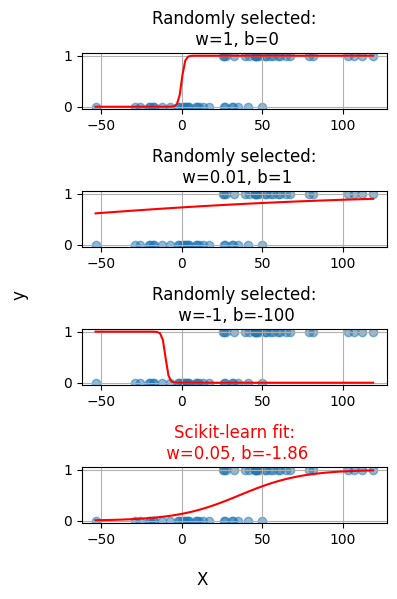

In [157]:
fig, ax = plt.subplots(4,1, figsize=(4,6))

plot_logistic(X, y, 1, 0, ax=ax[0])
ax[0].set_title('Randomly selected:\n w=1, b=0')
plot_logistic(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('Randomly selected:\n w=0.01, b=1')
plot_logistic(X, y, -1, -10, ax=ax[2])
ax[2].set_title('Randomly selected:\n w=-1, b=-100')
plot_logistic(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}'.format(params['coef'], params['intercept']),color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()

Those don't look too good! While it may be tempting to keep trying different combinations of `w` and `b` to get a better fit, that would be a poor use of our time. Moreover, we would have to go through the same process for each new data set we work with.

Instead, perhaps we could start with a random choice, and then iteratively update our parameters to try and get a better fit. At each update, we want to move the parameters so the fit gets better. But how do we measure if the fit is better? For this we will introduce the notion of a *loss function*.

## Loss function
The loss function reflects the difference between the actual class, $y$, and the predicted probability of that class,  $\hat{y}$. The lower value it has, the better the fit. To start building this function, let's consider the probability of $y$ given our prediction, $\hat{y}$, expressed as $p(y|\hat{y})$. Since $y$ is a binary variable (i.e. Cue or NoCue), we can express the probability as a Bernoulli distribution:

$$ p(y|\hat{y}) = \hat{y}^y(1-\hat{y})^{1-y} \tag{1}$$

Note that if $y=1$, we just return $\hat{y}$, because:

$$ \begin{align} 
    \notag p(1|\hat{y}) &= \hat{y}^1(1-\hat{y})^{1-1}  \\
    \notag &= \hat{y}^1(1-\hat{y})^{0} \\ 
    \notag &= \hat{y}^1\times 1 \\
    \notag &= \hat{y}
    \end{align}
$$


and if $y=0$, then $1-\hat{y}$ is returned:
$$ \begin{align} 
    \notag p(0|\hat{y}) &= \hat{y}^0(1-\hat{y})^{1-0}  \\
    \notag &= 1\times(1-\hat{y})^{1} \\ 
    \notag &= 1-\hat{y}
    \end{align}
$$

Alternatively, it might make more sense to you if we express equation 1 as a piecewise function.
$$ p(y|\hat{y})=\begin{cases}
    \hat{y} & y=1 \\
    1-\hat{y} & y=0
    \end{cases}
$$

Each possiblity is represented as a different case enclosed by the large bracket. Here y=1 when a cue occurs, and y=0 when no cue is present. If a cue occured, then we return the probability of the cue, $\hat{y}$. If no cue occured, then we return the probability that no cue occured, $1-\hat{y}$. 

How does equation 1 behave depending on $y$ and $\hat{y}$?

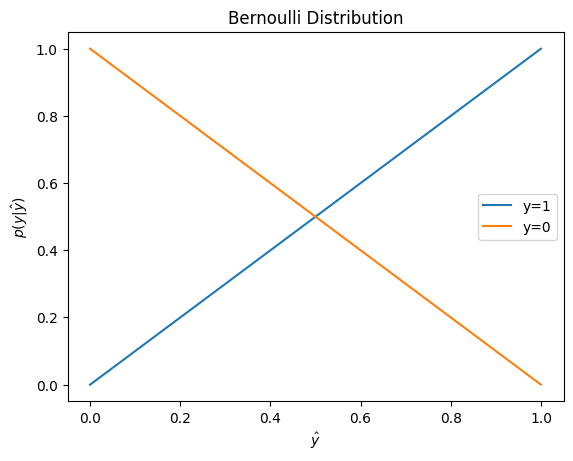

In [98]:
def bernoulli_dist(y, y_hat):
    return np.power(y_hat, y) * np.power(1-y_hat,1-y)

y_hat = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(y_hat, bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$p(y|\hat{y})$')
ax.set_title('Bernoulli Distribution')
ax.legend()
plt.show()

If we fit a model successfully so that it correctly predicts $y$, then trials with a cue ($y=1$) will return high values of $\hat{y}$. Correctly predicting no cue ($y=0$), will give high values as well since $1-\hat{y}$ is returned. Consequently, a model with good performance will on average give larger values for $p(y|\hat{y})$. We can use this to compare the random model fits above. 

To visualize this, we can add arrows to our logistic regression graph that represent the output of the Bernoulli probability function for each sample.

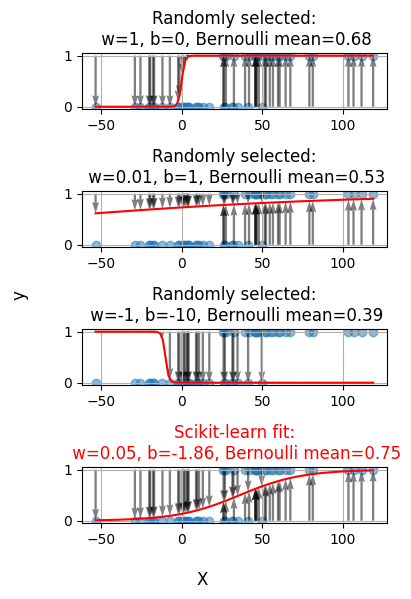

In [270]:
def plot_logistic_wloss(X_vals, y_vals, w, b, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax = plot_logistic(X_vals, y_vals, w, b, ax=ax)

    sign_y = np.sign(y_vals - 0.5)

    bern_vals = bernoulli_dist(y_vals, logistic(X_vals.squeeze(), w, b))
    ax.quiver(X_vals, 1-y_vals, np.zeros(y_vals.size), 
              sign_y*bern_vals, angles='xy', scale_units='xy', scale=1, alpha=0.5)
    return ax, np.mean(bern_vals)

fig, ax = plt.subplots(4,1, figsize=(4,6))

_, bern_sum = plot_logistic_wloss(X, y, 1, 0, ax=ax[0])
ax[0].set_title('Randomly selected:\n w=1, b=0, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_wloss(X, y, 0.01, 1, ax=ax[1])
ax[1].set_title('Randomly selected:\n w=0.01, b=1, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_wloss(X, y, -1, -10, ax=ax[2])
ax[2].set_title('Randomly selected:\n w=-1, b=-10, Bernoulli mean={:.2f}'.format(bern_sum))
_, bern_sum = plot_logistic_wloss(X, y, params['coef'], params['intercept'], ax=ax[3])
ax[3].set_title('Scikit-learn fit:\n w={:.2f}, b={:.2f}, Bernoulli mean={:.2f}'.format(params['coef'], params['intercept'], bern_sum), color='r')
fig.supxlabel('X')
fig.supylabel('y')
fig.tight_layout()


Each datapoint has a black arrow pointing at it, with longer arrows indicating a better match between the predicted and actual class. The one at the top has the a high mean probability. This is because it has more of its Cue trials on the high probability side, and NoCue trials on the low probability site. The second example is similar, but the logistic function is so broad that the expected probabilities, $\hat{y}$, are never close to 0 or 1. Worst is the third example, with a flat line hugging the x-axis that is only summing probabilities for NoCue trials. Lastly, the fitted parameters derived from the scikit-learn logisitic regression object have the highest, and best, mean probability.

The behavior of the Bernoulli probability function makes it a good basis for constructing our loss function. To improve it, first we will take its logarithm, instead of its output as is. 

$$ \begin{align}
    \notag \log(p(y|\hat{y})) &= \log(\hat{y}^y(1-\hat{y})^{1-y}) \\
    \notag &= y\log(\hat{y}) + (1-y)\log(1-\hat{y}) \\

    \end{align}
$$ 

(See the bottom for rules for working with logarithms). This changes the shape of the probability curves to give stronger weight mismatches between the predicted and actual classes. Put another way, wrong answers are penalized more than right ones. 

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_99663/735950708.py:3: RuntimeWarning: divide by zero encountered in log
  return (y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_99663/735950708.py:3: RuntimeWarning: invalid value encountered in multiply
  return (y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


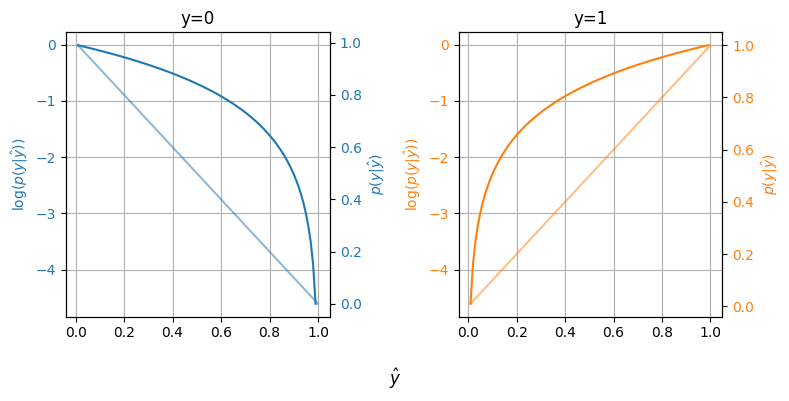

In [295]:
# log of the Bernoulli distribution
def log_bernoulli(y, y_hat):
    return (y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


# plot comparison of Bernoulli and log Bernoulli
x = np.linspace(0.01, 1, 100)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(x, log_bernoulli(0, x), label='log Bernoulli')
axb = ax[0].twinx()
axb.plot(x, bernoulli_dist(0, x), label='Bernoulli', color='tab:blue', alpha=0.5)
axb.tick_params(axis='y', labelcolor='tab:blue')
axb.set_ylabel('$p(y|\hat{y})$', color='tab:blue')
ax[0].set_title('y=0')
ax[0].grid()
ax[0].set_ylabel('$\log(p(y|\hat{y}))$', color='tab:blue')
ax[0].tick_params(axis='y', labelcolor='tab:blue')

ax[1].plot(x, log_bernoulli(1, x), label='log Bernoulli', color='tab:orange')
axb = ax[1].twinx()
axb.plot(x, bernoulli_dist(1, x), label='Bernoulli', color='tab:orange', alpha=0.5)
axb.tick_params(axis='y', labelcolor='tab:orange')
axb.set_ylabel('$p(y|\hat{y})$', color='tab:orange')
ax[1].set_title('y=1')
ax[1].grid()
ax[1].set_ylabel('$\log(p(y|\hat{y}))$', color='tab:orange')
ax[1].tick_params(axis='y', labelcolor='tab:orange')

fig.supxlabel(r'$\hat{y}$')
fig.tight_layout()


In [ ]:
# log loss function
def log_loss(y, y_hat):
    return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


# plot comparison of Bernoulli and log Bernoulli
x = np.linspace(0.01, 1, 100)

fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].plot(x, log_loss(0, x))
axb = ax[0].twinx()
axb.plot(x, bernoulli_dist(0, x), color='tab:blue', alpha=0.5)
axb.tick_params(axis='y', labelcolor='tab:blue')
axb.set_ylabel('$p(y|\hat{y})$', color='tab:blue')
ax[0].set_title('y=0')
ax[0].grid()
ax[0].set_ylabel('Loss')

ax[1].plot(x, log_loss(1, x), label='log Bernoulli', color='tab:orange')
axb = ax[1].twinx()
axb.plot(x, bernoulli_dist(1, x), label='Bernoulli', color='tab:orange', alpha=0.5)
axb.tick_params(axis='y', labelcolor='tab:orange')
axb.set_ylabel('$p(y|\hat{y})$', color='tab:orange')
ax[1].set_title('y=1')
ax[1].grid()
ax[1].set_ylabel('Loss')

fig.supxlabel(r'$\hat{y}$')
fig.tight_layout()

Text(0, 0.5, 'Negative Log Likelihood')

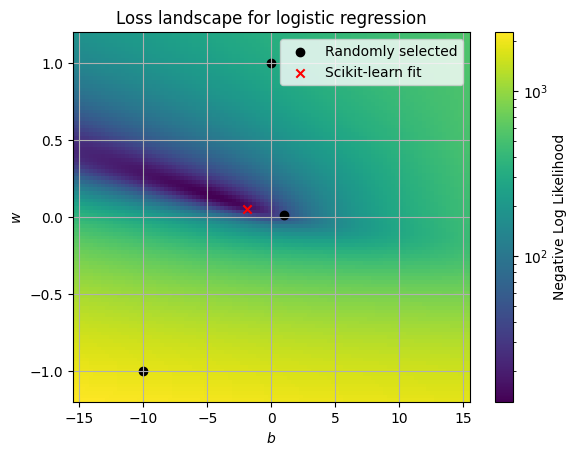

In [265]:
w_grid = np.linspace(-1.2, 1.2, 100)
b_grid = np.linspace(-15.5, 15.5, 100)
b_sum = np.zeros((w_grid.size, b_grid.size))
for i, w in enumerate(w_grid):
    for j, b in enumerate(b_grid):
        b_vals = bernoulli_dist(y, logistic(X.squeeze(), w, b))
        # set b_vals that are 0 to smallest floating point value to avoid log(0)
        b_vals[b_vals==0] = np.finfo(float).eps
        b_sum[i,j] = -np.sum(np.log(b_vals))

fig, ax = plt.subplots()
# imshow with w_grid, b_grid and b_sum
im = ax.imshow(b_sum, extent=[b_grid[0], b_grid[-1], w_grid[0], w_grid[-1]],
               norm=colors.LogNorm(), aspect='auto', origin='lower')
ax.scatter([0,1,-10],[1, 0.01, -1], marker='o', color='k', label='Randomly selected')
ax.scatter(params['intercept'], params['coef'], marker='x', color='r', label='Scikit-learn fit')
ax.legend()
ax.set_xlabel('$b$')
ax.set_ylabel('$w$')
ax.set_title('Loss landscape for logistic regression')
ax.grid()
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Negative Log Likelihood')


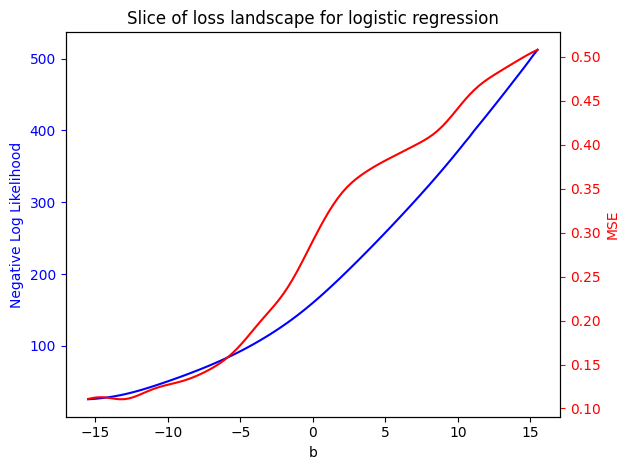

In [269]:
slice_idx = 70
# create two y-scale plot for b_sum and mse
fig, ax1 = plt.subplots()
ax1.plot(b_grid, b_sum[slice_idx,:], 'b')
ax1.set_xlabel('b')
ax1.set_ylabel('Negative Log Likelihood', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()
ax2.plot(b_grid, mse[slice_idx,:], 'r')
ax2.set_ylabel('MSE', color='r')
ax2.tick_params('y', colors='r')
ax1.set_title('Slice of loss landscape for logistic regression')
fig.tight_layout()

Text(0, 0.5, 'Mean sequared error')

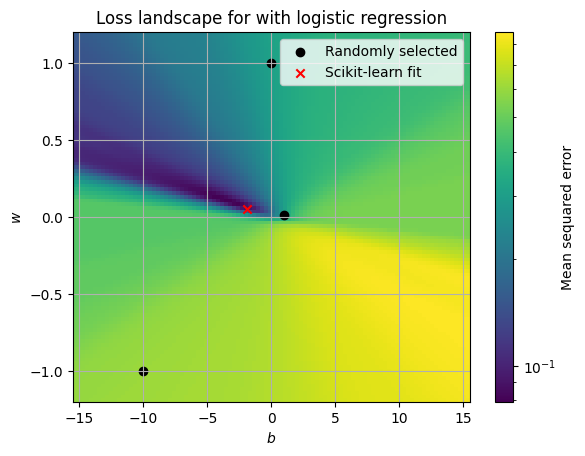

In [264]:
w_grid = np.linspace(-1.2, 1.2, 100)
b_grid = np.linspace(-15.5, 15.5, 100)
mse = np.zeros((w_grid.size, b_grid.size))
for i, w in enumerate(w_grid):
    for j, b in enumerate(b_grid):
        mse[i,j] = np.mean((y-logistic(X.squeeze(), w, b))**2)

fig, ax = plt.subplots()
# imshow with w_grid, b_grid and b_sum
im = ax.imshow(mse, extent=[b_grid[0], b_grid[-1], w_grid[0], w_grid[-1]],
               norm=colors.LogNorm(), aspect='auto', origin='lower')
ax.scatter([0,1,-10],[1, 0.01, -1], marker='o', color='k', label='Randomly selected')
ax.scatter(params['intercept'], params['coef'], marker='x', color='r', label='Scikit-learn fit')
ax.legend()
ax.set_xlabel('$b$')
ax.set_ylabel('$w$')
ax.set_title('Loss landscape for with logistic regression')
ax.grid()
cbar = fig.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Mean sequared error')

BERNOULLI DISTRIBUTION

OPTIMIZATION/FITTING

LOSS FUNCTION

BINARY CROSS ENTROPY LOSS FUNCTION

DERIVATIVE OF LOSS FUNCTION

GRADIENT DESCENT


/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/2771818357.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x, np.log(x), label='log(x)')


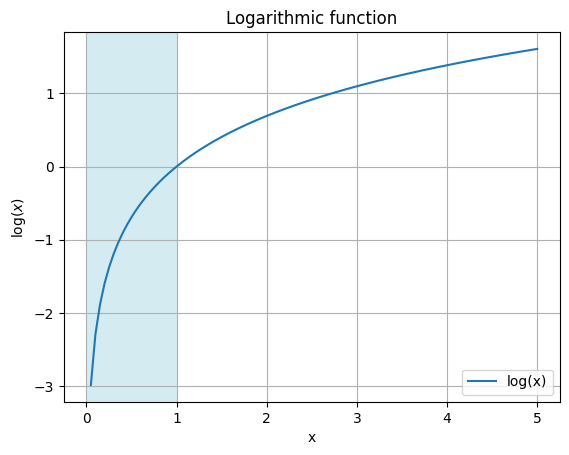

In [16]:
x = np.linspace(0, 5, 100)

plt.plot(x, np.log(x), label='log(x)')
plt.xlabel('x')
plt.ylabel('$\log(x)$')
plt.title('Logarithmic function')
plt.grid()
plt.axvspan(0, 1, facecolor='lightblue', alpha=0.5)
plt.legend()


1. $\log(xy) = \log(x) + \log(y)$
2. $\log\left(\frac{x}{y}\right) = \log(x) - \log(y)$
3. $\log(x^n) = n\log(x)$
4. $\log(1) = 0$
5. $\log(0) = -\inf$

$$ \log(p(y|x))=y\log(\hat{y})+(1-y)\log(1-\hat{y})$$

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/854167381.py:2: RuntimeWarning: divide by zero encountered in log
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/854167381.py:2: RuntimeWarning: invalid value encountered in multiply
  return -(y*np.log(y_hat) + (1-y)*np.log(1-y_hat))


Text(0.5, 1.0, 'Log Loss')

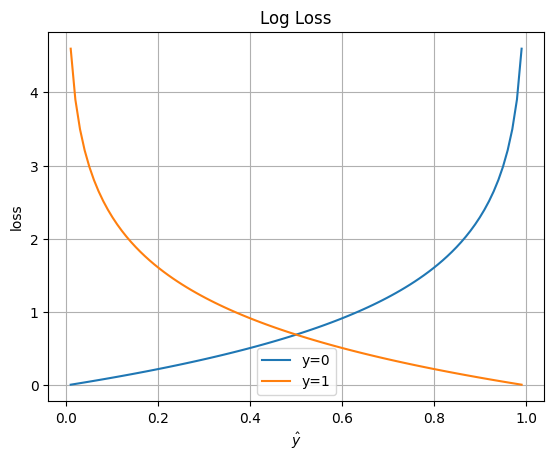


$$ \begin{align}
    \notag \frac{\partial{L}}{\partial{w}}&=\frac{\partial}{\partial{w}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))\\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}1-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{w}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{w}}-\sigma(wx+b)\right)\right) \\
    \notag &=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{w}}\sigma(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))\frac{\partial}{\partial{w}}(wx+b) \\
    \notag &=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))x \\
    \notag &=-(y-\sigma(wx+b))x \\
    \notag &= (\sigma(wx+b)-y)x \\
\end{align}
$$

$$ \begin{align}
    \notag \textcolor{lightgray}{\frac{\partial{L}}{\partial{b}}}&\textcolor{lightgray}{=\frac{\partial}{\partial{b}}-(y\log(\sigma(wx+b))+(1-y)\log(1-\sigma(wx+b)))}\\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}1-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\left(\frac{y}{\sigma(wx+b)}\frac{\partial}{\partial{b}}\sigma(wx+b)\right)+\left(\frac{1-y}{1-\sigma(wx+b)}\frac{\partial}{\partial{b}}-\sigma(wx+b)\right)\right)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y}{\sigma(wx+b)}-\frac{1-y}{1-\sigma(wx+b)}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y(1-\sigma(wx+b))}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{(1-y)\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}-\frac{\sigma(wx+b)-y\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\frac{\partial}{\partial{b}}\sigma(wx+b)} \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))}\frac{\partial}{\partial{b}}(wx+b) \\
    \notag &\textcolor{lightgray}{=-\left(\frac{y-\sigma(wx+b)}{\sigma(wx+b)(1-\sigma(wx+b))}\right)\sigma(wx+b)(1-\sigma(wx+b))} \cdot 1 \\
    \notag &=-(y-\sigma(wx+b)) \\
    \notag &= \sigma(wx+b)-y \\
\end{align}
$$

/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/3150900135.py:2: RuntimeWarning: divide by zero encountered in log
  return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)
/var/folders/xr/cvz2q4cs7mn5n78kvjyvkb_00000gn/T/ipykernel_94054/3150900135.py:2: RuntimeWarning: invalid value encountered in multiply
  return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)


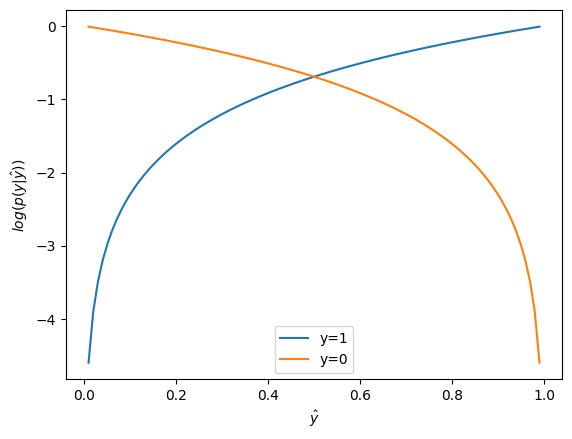

In [7]:
def log_bernoulli_dist(y, y_hat):
    return y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)

y_hat = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
ax.plot(y_hat, log_bernoulli_dist(1, y_hat), label='y=1')
ax.plot(y_hat, log_bernoulli_dist(0, y_hat), label='y=0')
ax.set_xlabel(r'$\hat{y}$')
ax.set_ylabel(r'$log(p(y|\hat{y}))$')
ax.legend()
plt.show()